In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=2 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 29576 
    Total predicted counts          : 29610.59
    Total off counts                : 101754.00

    Total background counts         : 20350.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 31 s, sys: 255 ms, total: 31.2 s
Wall time: 35.9 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 29631 
    Total predicted counts          : 29672.79
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 29292 
    Total predicted counts          : 29715.59
    Total off counts                : 102279.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_11 

    Total counts                    : 29457 
    Total predicted counts          : 29560.79
    Total off counts                : 101505.00

    Total background counts         : 20301.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 29659 
    Total predicted counts          : 29604.79
    Total off counts                : 101725.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_24 

    Total counts                    : 29692 
    Total predicted counts          : 29615.39
    Total off counts                : 101778.00

    Total background counts         : 20355.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_25 

    Total counts                    : 29709 
    Total predicted counts          : 29657.39
    Total off counts                : 101988.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_36 

    Total counts                    : 29620 
    Total predicted counts          : 29519.99
    Total off counts                : 101301.00

    Total background counts         : 20260.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_37 

    Total counts                    : 29566 
    Total predicted counts          : 29637.59
    Total off counts                : 101889.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_47 

    Total counts                    : 29634 
    Total predicted counts          : 29593.79
    Total off counts                : 101670.00

    Total background counts         : 20334.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_48 

    Total counts                    : 29358 
    Total predicted counts          : 29439.99
    Total off counts                : 100901.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_58 

    Total counts                    : 29491 
    Total predicted counts          : 29562.79
    Total off counts                : 101515.00

    Total background counts         : 20303.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 29566 
    Total predicted counts          : 29543.19
    Total off counts                : 101417.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_70 

    Total counts                    : 29637 
    Total predicted counts          : 29455.59
    Total off counts                : 100979.00

    Total background counts         : 20195.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_71 

    Total counts                    : 29654 
    Total predicted counts          : 29598.79
    Total off counts                : 101695.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_82 

    Total counts                    : 29333 
    Total predicted counts          : 29590.39
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_83 

    Total counts                    : 29585 
    Total predicted counts          : 29487.59
    Total off counts                : 101139.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_96 

    Total counts                    : 29491 
    Total predicted counts          : 29548.19
    Total off counts                : 101442.00

    Total background counts         : 20288.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_97 

    Total counts                    : 29435 
    Total predicted counts          : 29692.79
    Total off counts                : 102165.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_108 

    Total counts                    : 29437 
    Total predicted counts          : 29540.39
    Total off counts                : 101403.00

    Total background counts         : 20280.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_109 

    Total counts                    : 29636 
    Total predicted counts          : 29751.39
    Total off counts                : 102458.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_121 

    Total counts                    : 29433 
    Total predicted counts          : 29554.19
    Total off counts                : 101472.00

    Total background counts         : 20294.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_122 

    Total counts                    : 29344 
    Total predicted counts          : 29527.79
    Total off counts                : 101340.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_134 

    Total counts                    : 29525 
    Total predicted counts          : 29451.39
    Total off counts                : 100958.00

    Total background counts         : 20191.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_135 

    Total counts                    : 29708 
    Total predicted counts          : 29664.59
    Total off counts                : 102024.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_147 

    Total counts                    : 29404 
    Total predicted counts          : 29518.39
    Total off counts                : 101293.00

    Total background counts         : 20258.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_148 

    Total counts                    : 29355 
    Total predicted counts          : 29672.99
    Total off counts                : 102066.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 29766 
    Total predicted counts          : 29560.19
    Total off counts                : 101502.00

    Total background counts         : 20300.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_163 

    Total counts                    : 29804 
    Total predicted counts          : 29540.39
    Total off counts                : 101403.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_177 

    Total counts                    : 29536 
    Total predicted counts          : 29662.19
    Total off counts                : 102012.00

    Total background counts         : 20402.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_178 

    Total counts                    : 29543 
    Total predicted counts          : 29511.19
    Total off counts                : 101257.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 29385 
    Total predicted counts          : 29600.39
    Total off counts                : 101703.00

    Total background counts         : 20340.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 29600 
    Total predicted counts          : 29547.19
    Total off counts                : 101437.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_206 

    Total counts                    : 29549 
    Total predicted counts          : 29603.99
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_207 

    Total counts                    : 29632 
    Total predicted counts          : 29702.59
    Total off counts                : 102214.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_217 

    Total counts                    : 29457 
    Total predicted counts          : 29607.99
    Total off counts                : 101741.00

    Total background counts         : 20348.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_218 

    Total counts                    : 29657 
    Total predicted counts          : 29513.99
    Total off counts                : 101271.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_228 

    Total counts                    : 29775 
    Total predicted counts          : 29501.39
    Total off counts                : 101208.00

    Total background counts         : 20241.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_229 

    Total counts                    : 29629 
    Total predicted counts          : 29653.19
    Total off counts                : 101967.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_241 

    Total counts                    : 29580 
    Total predicted counts          : 29493.99
    Total off counts                : 101171.00

    Total background counts         : 20234.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_242 

    Total counts                    : 29631 
    Total predicted counts          : 29531.79
    Total off counts                : 101360.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_254 

    Total counts                    : 29532 
    Total predicted counts          : 29700.59
    Total off counts                : 102204.00

    Total background counts         : 20440.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_255 

    Total counts                    : 29581 
    Total predicted counts          : 29571.79
    Total off counts                : 101560.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_267 

    Total counts                    : 29529 
    Total predicted counts          : 29581.79
    Total off counts                : 101610.00

    Total background counts         : 20322.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_268 

    Total counts                    : 29571 
    Total predicted counts          : 29470.99
    Total off counts                : 101056.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 29419 
    Total predicted counts          : 29578.39
    Total off counts                : 101593.00

    Total background counts         : 20318.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_283 

    Total counts                    : 29450 
    Total predicted counts          : 29535.59
    Total off counts                : 101379.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_296 

    Total counts                    : 29820 
    Total predicted counts          : 29677.99
    Total off counts                : 102091.00

    Total background counts         : 20418.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_297 

    Total counts                    : 29594 
    Total predicted counts          : 29528.59
    Total off counts                : 101344.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_308 

    Total counts                    : 29563 
    Total predicted counts          : 29422.99
    Total off counts                : 100816.00

    Total background counts         : 20163.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_309 

    Total counts                    : 29819 
    Total predicted counts          : 29685.79
    Total off counts                : 102130.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_321 

    Total counts                    : 29637 
    Total predicted counts          : 29531.19
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_322 

    Total counts                    : 29514 
    Total predicted counts          : 29481.19
    Total off counts                : 101107.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_332 

    Total counts                    : 29738 
    Total predicted counts          : 29568.39
    Total off counts                : 101543.00

    Total background counts         : 20308.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_333 

    Total counts                    : 29621 
    Total predicted counts          : 29555.79
    Total off counts                : 101480.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_347 

    Total counts                    : 29453 
    Total predicted counts          : 29494.59
    Total off counts                : 101174.00

    Total background counts         : 20234.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_348 

    Total counts                    : 29167 
    Total predicted counts          : 29472.99
    Total off counts                : 101066.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_360 

    Total counts                    : 29650 
    Total predicted counts          : 29529.79
    Total off counts                : 101350.00

    Total background counts         : 20270.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_361 

    Total counts                    : 29571 
    Total predicted counts          : 29511.19
    Total off counts                : 101257.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_373 

    Total counts                    : 29718 
    Total predicted counts          : 29629.79
    Total off counts                : 101850.00

    Total background counts         : 20370.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_374 

    Total counts                    : 29583 
    Total predicted counts          : 29698.99
    Total off counts                : 102196.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_387 

    Total counts                    : 29450 
    Total predicted counts          : 29581.19
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_388 

    Total counts                    : 29749 
    Total predicted counts          : 29499.59
    Total off counts                : 101199.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_400 

    Total counts                    : 29695 
    Total predicted counts          : 29617.99
    Total off counts                : 101791.00

    Total background counts         : 20358.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_401 

    Total counts                    : 29578 
    Total predicted counts          : 29576.79
    Total off counts                : 101585.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_413 

    Total counts                    : 29588 
    Total predicted counts          : 29529.39
    Total off counts                : 101348.00

    Total background counts         : 20269.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_414 

    Total counts                    : 29884 
    Total predicted counts          : 29606.19
    Total off counts                : 101732.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_429 

    Total counts                    : 29626 
    Total predicted counts          : 29472.79
    Total off counts                : 101065.00

    Total background counts         : 20213.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_430 

    Total counts                    : 29497 
    Total predicted counts          : 29626.99
    Total off counts                : 101836.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_445 

    Total counts                    : 29706 
    Total predicted counts          : 29494.39
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_446 

    Total counts                    : 29647 
    Total predicted counts          : 29613.79
    Total off counts                : 101770.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_460 

    Total counts                    : 29642 
    Total predicted counts          : 29568.79
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_461 

    Total counts                    : 29265 
    Total predicted counts          : 29628.59
    Total off counts                : 101844.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_475 

    Total counts                    : 29377 
    Total predicted counts          : 29566.79
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_476 

    Total counts                    : 29386 
    Total predicted counts          : 29648.59
    Total off counts                : 101944.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_492 

    Total counts                    : 29549 
    Total predicted counts          : 29646.99
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_493 

    Total counts                    : 29672 
    Total predicted counts          : 29544.79
    Total off counts                : 101425.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_512 

    Total counts                    : 29307 
    Total predicted counts          : 29435.59
    Total off counts                : 100879.00

    Total background counts         : 20175.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_513 

    Total counts                    : 29684 
    Total predicted counts          : 29578.99
    Total off counts                : 101596.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_527 

    Total counts                    : 29622 
    Total predicted counts          : 29528.59
    Total off counts                : 101344.00

    Total background counts         : 20268.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_528 

    Total counts                    : 29347 
    Total predicted counts          : 29564.39
    Total off counts                : 101523.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_540 

    Total counts                    : 29625 
    Total predicted counts          : 29543.99
    Total off counts                : 101421.00

    Total background counts         : 20284.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_541 

    Total counts                    : 29494 
    Total predicted counts          : 29610.99
    Total off counts                : 101756.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_555 

    Total counts                    : 29702 
    Total predicted counts          : 29509.39
    Total off counts                : 101248.00

    Total background counts         : 20249.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_556 

    Total counts                    : 29698 
    Total predicted counts          : 29531.79
    Total off counts                : 101360.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_567 

    Total counts                    : 29798 
    Total predicted counts          : 29584.39
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_568 

    Total counts                    : 29380 
    Total predicted counts          : 29521.59
    Total off counts                : 101309.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_581 

    Total counts                    : 29533 
    Total predicted counts          : 29564.59
    Total off counts                : 101524.00

    Total background counts         : 20304.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_582 

    Total counts                    : 29373 
    Total predicted counts          : 29646.99
    Total off counts                : 101936.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_596 

    Total counts                    : 29374 
    Total predicted counts          : 29503.19
    Total off counts                : 101217.00

    Total background counts         : 20243.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_597 

    Total counts                    : 29473 
    Total predicted counts          : 29565.19
    Total off counts                : 101527.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_612 

    Total counts                    : 29764 
    Total predicted counts          : 29660.39
    Total off counts                : 102003.00

    Total background counts         : 20400.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_613 

    Total counts                    : 29559 
    Total predicted counts          : 29548.79
    Total off counts                : 101445.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_625 

    Total counts                    : 29146 
    Total predicted counts          : 29581.39
    Total off counts                : 101608.00

    Total background counts         : 20321.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_626 

    Total counts                    : 29443 
    Total predicted counts          : 29525.99
    Total off counts                : 101331.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_639 

    Total counts                    : 29648 
    Total predicted counts          : 29589.39
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_640 

    Total counts                    : 29347 
    Total predicted counts          : 29677.59
    Total off counts                : 102089.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_655 

    Total counts                    : 29753 
    Total predicted counts          : 29539.79
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_656 

    Total counts                    : 29552 
    Total predicted counts          : 29628.39
    Total off counts                : 101843.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_671 

    Total counts                    : 29929 
    Total predicted counts          : 29534.79
    Total off counts                : 101375.00

    Total background counts         : 20275.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_672 

    Total counts                    : 29565 
    Total predicted counts          : 29636.99
    Total off counts                : 101886.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_684 

    Total counts                    : 29528 
    Total predicted counts          : 29591.59
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_685 

    Total counts                    : 29687 
    Total predicted counts          : 29565.19
    Total off counts                : 101527.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_698 

    Total counts                    : 29280 
    Total predicted counts          : 29607.59
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_699 

    Total counts                    : 29853 
    Total predicted counts          : 29543.79
    Total off counts                : 101420.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_712 

    Total counts                    : 29596 
    Total predicted counts          : 29648.79
    Total off counts                : 101945.00

    Total background counts         : 20389.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_713 

    Total counts                    : 29603 
    Total predicted counts          : 29589.19
    Total off counts                : 101647.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_726 

    Total counts                    : 29428 
    Total predicted counts          : 29622.99
    Total off counts                : 101816.00

    Total background counts         : 20363.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_727 

    Total counts                    : 29409 
    Total predicted counts          : 29530.39
    Total off counts                : 101353.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_741 

    Total counts                    : 29303 
    Total predicted counts          : 29543.39
    Total off counts                : 101418.00

    Total background counts         : 20283.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_742 

    Total counts                    : 29542 
    Total predicted counts          : 29546.19
    Total off counts                : 101432.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_754 

    Total counts                    : 29542 
    Total predicted counts          : 29635.39
    Total off counts                : 101878.00

    Total background counts         : 20375.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_755 

    Total counts                    : 29621 
    Total predicted counts          : 29559.19
    Total off counts                : 101497.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_766 

    Total counts                    : 29419 
    Total predicted counts          : 29647.19
    Total off counts                : 101937.00

    Total background counts         : 20387.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_767 

    Total counts                    : 29240 
    Total predicted counts          : 29561.79
    Total off counts                : 101510.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_781 

    Total counts                    : 29612 
    Total predicted counts          : 29445.99
    Total off counts                : 100931.00

    Total background counts         : 20186.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_782 

    Total counts                    : 29495 
    Total predicted counts          : 29525.39
    Total off counts                : 101328.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_796 

    Total counts                    : 29611 
    Total predicted counts          : 29466.19
    Total off counts                : 101032.00

    Total background counts         : 20206.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_797 

    Total counts                    : 29440 
    Total predicted counts          : 29632.19
    Total off counts                : 101862.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_809 

    Total counts                    : 29656 
    Total predicted counts          : 29551.99
    Total off counts                : 101461.00

    Total background counts         : 20292.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_810 

    Total counts                    : 29815 
    Total predicted counts          : 29667.59
    Total off counts                : 102039.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_822 

    Total counts                    : 29549 
    Total predicted counts          : 29546.79
    Total off counts                : 101435.00

    Total background counts         : 20287.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_823 

    Total counts                    : 29771 
    Total predicted counts          : 29509.59
    Total off counts                : 101249.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_837 

    Total counts                    : 29549 
    Total predicted counts          : 29547.39
    Total off counts                : 101438.00

    Total background counts         : 20287.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_838 

    Total counts                    : 29963 
    Total predicted counts          : 29675.99
    Total off counts                : 102081.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_854 

    Total counts                    : 29627 
    Total predicted counts          : 29558.79
    Total off counts                : 101495.00

    Total background counts         : 20299.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_855 

    Total counts                    : 29346 
    Total predicted counts          : 29618.19
    Total off counts                : 101792.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_869 

    Total counts                    : 29520 
    Total predicted counts          : 29590.59
    Total off counts                : 101654.00

    Total background counts         : 20330.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_870 

    Total counts                    : 29231 
    Total predicted counts          : 29521.99
    Total off counts                : 101311.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_889 

    Total counts                    : 29641 
    Total predicted counts          : 29482.19
    Total off counts                : 101112.00

    Total background counts         : 20222.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_890 

    Total counts                    : 29479 
    Total predicted counts          : 29501.79
    Total off counts                : 101210.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_908 

    Total counts                    : 29475 
    Total predicted counts          : 29593.19
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_909 

    Total counts                    : 29401 
    Total predicted counts          : 29646.79
    Total off counts                : 101935.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_927 

    Total counts                    : 29472 
    Total predicted counts          : 29645.99
    Total off counts                : 101931.00

    Total background counts         : 20386.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_928 

    Total counts                    : 29743 
    Total predicted counts          : 29611.79
    Total off counts                : 101760.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_941 

    Total counts                    : 29644 
    Total predicted counts          : 29554.99
    Total off counts                : 101476.00

    Total background counts         : 20295.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_942 

    Total counts                    : 29238 
    Total predicted counts          : 29578.39
    Total off counts                : 101593.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_957 

    Total counts                    : 29720 
    Total predicted counts          : 29532.99
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_958 

    Total counts                    : 29722 
    Total predicted counts          : 29524.19
    Total off counts                : 101322.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_975 

    Total counts                    : 29457 
    Total predicted counts          : 29496.59
    Total off counts                : 101184.00

    Total background counts         : 20236.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_976 

    Total counts                    : 29741 
    Total predicted counts          : 29548.59
    Total off counts                : 101444.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_991 

    Total counts                    : 29716 
    Total predicted counts          : 29695.99
    Total off counts                : 102181.00

    Total background counts         : 20436.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_992 

    Total counts                    : 29589 
    Total predicted counts          : 29477.79
    Total off counts                : 101090.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1005 

    Total counts                    : 29525 
    Total predicted counts          : 29610.79
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1006 

    Total counts                    : 29518 
    Total predicted counts          : 29609.79
    Total off counts                : 101750.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1022 

    Total counts                    : 29453 
    Total predicted counts          : 29530.19
    Total off counts                : 101352.00

    Total background counts         : 20270.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1023 

    Total counts                    : 29665 
    Total predicted counts          : 29592.59
    Total off counts                : 101664.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1037 

    Total counts                    : 29504 
    Total predicted counts          : 29616.39
    Total off counts                : 101783.00

    Total background counts         : 20356.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1038 

    Total counts                    : 29856 
    Total predicted counts          : 29558.19
    Total off counts                : 101492.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1052 

    Total counts                    : 29581 
    Total predicted counts          : 29528.79
    Total off counts                : 101345.00

    Total background counts         : 20269.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1053 

    Total counts                    : 29767 
    Total predicted counts          : 29644.19
    Total off counts                : 101922.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1066 

    Total counts                    : 29692 
    Total predicted counts          : 29590.99
    Total off counts                : 101656.00

    Total background counts         : 20331.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1067 

    Total counts                    : 29357 
    Total predicted counts          : 29581.39
    Total off counts                : 101608.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1081 

    Total counts                    : 29711 
    Total predicted counts          : 29530.19
    Total off counts                : 101352.00

    Total background counts         : 20270.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1082 

    Total counts                    : 29925 
    Total predicted counts          : 29456.59
    Total off counts                : 100984.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1096 

    Total counts                    : 29600 
    Total predicted counts          : 29600.79
    Total off counts                : 101705.00

    Total background counts         : 20341.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1097 

    Total counts                    : 29603 
    Total predicted counts          : 29666.79
    Total off counts                : 102035.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1112 

    Total counts                    : 29602 
    Total predicted counts          : 29532.59
    Total off counts                : 101364.00

    Total background counts         : 20272.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1113 

    Total counts                    : 29628 
    Total predicted counts          : 29521.19
    Total off counts                : 101307.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1130 

    Total counts                    : 29579 
    Total predicted counts          : 29468.99
    Total off counts                : 101046.00

    Total background counts         : 20209.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1131 

    Total counts                    : 29384 
    Total predicted counts          : 29626.99
    Total off counts                : 101836.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1144 

    Total counts                    : 29587 
    Total predicted counts          : 29599.79
    Total off counts                : 101700.00

    Total background counts         : 20340.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1145 

    Total counts                    : 29740 
    Total predicted counts          : 29635.59
    Total off counts                : 101879.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1157 

    Total counts                    : 29628 
    Total predicted counts          : 29564.19
    Total off counts                : 101522.00

    Total background counts         : 20304.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1158 

    Total counts                    : 29651 
    Total predicted counts          : 29518.99
    Total off counts                : 101296.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1171 

    Total counts                    : 29513 
    Total predicted counts          : 29452.59
    Total off counts                : 100964.00

    Total background counts         : 20192.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1172 

    Total counts                    : 29743 
    Total predicted counts          : 29556.39
    Total off counts                : 101483.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1185 

    Total counts                    : 29621 
    Total predicted counts          : 29569.79
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1186 

    Total counts                    : 29908 
    Total predicted counts          : 29472.59
    Total off counts                : 101064.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1197 

    Total counts                    : 29851 
    Total predicted counts          : 29598.99
    Total off counts                : 101696.00

    Total background counts         : 20339.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1198 

    Total counts                    : 29669 
    Total predicted counts          : 29631.39
    Total off counts                : 101858.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1211 

    Total counts                    : 29619 
    Total predicted counts          : 29526.19
    Total off counts                : 101332.00

    Total background counts         : 20266.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1212 

    Total counts                    : 29363 
    Total predicted counts          : 29598.59
    Total off counts                : 101694.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1226 

    Total counts                    : 29562 
    Total predicted counts          : 29644.19
    Total off counts                : 101922.00

    Total background counts         : 20384.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1227 

    Total counts                    : 29666 
    Total predicted counts          : 29575.39
    Total off counts                : 101578.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1240 

    Total counts                    : 29632 
    Total predicted counts          : 29602.39
    Total off counts                : 101713.00

    Total background counts         : 20342.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1241 

    Total counts                    : 29382 
    Total predicted counts          : 29563.59
    Total off counts                : 101519.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1255 

    Total counts                    : 29227 
    Total predicted counts          : 29738.59
    Total off counts                : 102394.00

    Total background counts         : 20478.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1256 

    Total counts                    : 29513 
    Total predicted counts          : 29685.59
    Total off counts                : 102129.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1268 

    Total counts                    : 29263 
    Total predicted counts          : 29621.79
    Total off counts                : 101810.00

    Total background counts         : 20362.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1269 

    Total counts                    : 29511 
    Total predicted counts          : 29568.39
    Total off counts                : 101543.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1282 

    Total counts                    : 29592 
    Total predicted counts          : 29514.39
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1283 

    Total counts                    : 29337 
    Total predicted counts          : 29626.19
    Total off counts                : 101832.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1295 

    Total counts                    : 29533 
    Total predicted counts          : 29605.19
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1296 

    Total counts                    : 29599 
    Total predicted counts          : 29619.79
    Total off counts                : 101800.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1308 

    Total counts                    : 29363 
    Total predicted counts          : 29563.39
    Total off counts                : 101518.00

    Total background counts         : 20303.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1309 

    Total counts                    : 29528 
    Total predicted counts          : 29627.99
    Total off counts                : 101841.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1323 

    Total counts                    : 29379 
    Total predicted counts          : 29560.39
    Total off counts                : 101503.00

    Total background counts         : 20300.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1324 

    Total counts                    : 29314 
    Total predicted counts          : 29484.19
    Total off counts                : 101122.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1336 

    Total counts                    : 29458 
    Total predicted counts          : 29549.99
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1337 

    Total counts                    : 29583 
    Total predicted counts          : 29525.99
    Total off counts                : 101331.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1350 

    Total counts                    : 29678 
    Total predicted counts          : 29626.39
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1351 

    Total counts                    : 29556 
    Total predicted counts          : 29523.79
    Total off counts                : 101320.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1363 

    Total counts                    : 29933 
    Total predicted counts          : 29539.19
    Total off counts                : 101397.00

    Total background counts         : 20279.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1364 

    Total counts                    : 29253 
    Total predicted counts          : 29613.19
    Total off counts                : 101767.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1375 

    Total counts                    : 29592 
    Total predicted counts          : 29592.19
    Total off counts                : 101662.00

    Total background counts         : 20332.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1376 

    Total counts                    : 29742 
    Total predicted counts          : 29534.39
    Total off counts                : 101373.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1389 

    Total counts                    : 29563 
    Total predicted counts          : 29500.39
    Total off counts                : 101203.00

    Total background counts         : 20240.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1390 

    Total counts                    : 29526 
    Total predicted counts          : 29515.59
    Total off counts                : 101279.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1403 

    Total counts                    : 29692 
    Total predicted counts          : 29697.19
    Total off counts                : 102187.00

    Total background counts         : 20437.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1404 

    Total counts                    : 29587 
    Total predicted counts          : 29607.39
    Total off counts                : 101738.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1419 

    Total counts                    : 29586 
    Total predicted counts          : 29583.79
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1420 

    Total counts                    : 29893 
    Total predicted counts          : 29536.19
    Total off counts                : 101382.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1434 

    Total counts                    : 29075 
    Total predicted counts          : 29564.79
    Total off counts                : 101525.00

    Total background counts         : 20305.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1435 

    Total counts                    : 29491 
    Total predicted counts          : 29624.79
    Total off counts                : 101825.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1448 

    Total counts                    : 29515 
    Total predicted counts          : 29523.99
    Total off counts                : 101321.00

    Total background counts         : 20264.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1449 

    Total counts                    : 29738 
    Total predicted counts          : 29508.99
    Total off counts                : 101246.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1463 

    Total counts                    : 29798 
    Total predicted counts          : 29577.99
    Total off counts                : 101591.00

    Total background counts         : 20318.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1464 

    Total counts                    : 29695 
    Total predicted counts          : 29568.79
    Total off counts                : 101545.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1477 

    Total counts                    : 29561 
    Total predicted counts          : 29472.79
    Total off counts                : 101065.00

    Total background counts         : 20213.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1478 

    Total counts                    : 29625 
    Total predicted counts          : 29628.19
    Total off counts                : 101842.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1489 

    Total counts                    : 29206 
    Total predicted counts          : 29553.79
    Total off counts                : 101470.00

    Total background counts         : 20294.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1490 

    Total counts                    : 29431 
    Total predicted counts          : 29496.39
    Total off counts                : 101183.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1502 

    Total counts                    : 29493 
    Total predicted counts          : 29633.19
    Total off counts                : 101867.00

    Total background counts         : 20373.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1503 

    Total counts                    : 29597 
    Total predicted counts          : 29679.99
    Total off counts                : 102101.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1517 

    Total counts                    : 29617 
    Total predicted counts          : 29623.79
    Total off counts                : 101820.00

    Total background counts         : 20364.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1518 

    Total counts                    : 29892 
    Total predicted counts          : 29579.99
    Total off counts                : 101601.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1529 

    Total counts                    : 29287 
    Total predicted counts          : 29540.59
    Total off counts                : 101404.00

    Total background counts         : 20280.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1530 

    Total counts                    : 29348 
    Total predicted counts          : 29518.39
    Total off counts                : 101293.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1543 

    Total counts                    : 29703 
    Total predicted counts          : 29610.19
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1544 

    Total counts                    : 29404 
    Total predicted counts          : 29526.99
    Total off counts                : 101336.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1556 

    Total counts                    : 29674 
    Total predicted counts          : 29475.59
    Total off counts                : 101079.00

    Total background counts         : 20215.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1557 

    Total counts                    : 29614 
    Total predicted counts          : 29680.39
    Total off counts                : 102103.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1570 

    Total counts                    : 29589 
    Total predicted counts          : 29611.99
    Total off counts                : 101761.00

    Total background counts         : 20352.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1571 

    Total counts                    : 29520 
    Total predicted counts          : 29604.39
    Total off counts                : 101723.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1584 

    Total counts                    : 29465 
    Total predicted counts          : 29553.39
    Total off counts                : 101468.00

    Total background counts         : 20293.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1585 

    Total counts                    : 29552 
    Total predicted counts          : 29599.19
    Total off counts                : 101697.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1597 

    Total counts                    : 29859 
    Total predicted counts          : 29610.19
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1598 

    Total counts                    : 29472 
    Total predicted counts          : 29609.99
    Total off counts                : 101751.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1612 

    Total counts                    : 29569 
    Total predicted counts          : 29579.19
    Total off counts                : 101597.00

    Total background counts         : 20319.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1613 

    Total counts                    : 29530 
    Total predicted counts          : 29581.39
    Total off counts                : 101608.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1626 

    Total counts                    : 29529 
    Total predicted counts          : 29604.39
    Total off counts                : 101723.00

    Total background counts         : 20344.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1627 

    Total counts                    : 29491 
    Total predicted counts          : 29597.39
    Total off counts                : 101688.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1640 

    Total counts                    : 29840 
    Total predicted counts          : 29492.59
    Total off counts                : 101164.00

    Total background counts         : 20232.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1641 

    Total counts                    : 29648 
    Total predicted counts          : 29542.79
    Total off counts                : 101415.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1654 

    Total counts                    : 29850 
    Total predicted counts          : 29566.19
    Total off counts                : 101532.00

    Total background counts         : 20306.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1655 

    Total counts                    : 29615 
    Total predicted counts          : 29595.99
    Total off counts                : 101681.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1667 

    Total counts                    : 29481 
    Total predicted counts          : 29543.99
    Total off counts                : 101421.00

    Total background counts         : 20284.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1668 

    Total counts                    : 29704 
    Total predicted counts          : 29514.79
    Total off counts                : 101275.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1679 

    Total counts                    : 29607 
    Total predicted counts          : 29682.59
    Total off counts                : 102114.00

    Total background counts         : 20422.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1680 

    Total counts                    : 29296 
    Total predicted counts          : 29594.39
    Total off counts                : 101673.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1691 

    Total counts                    : 29590 
    Total predicted counts          : 29542.79
    Total off counts                : 101415.00

    Total background counts         : 20283.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1692 

    Total counts                    : 29462 
    Total predicted counts          : 29607.39
    Total off counts                : 101738.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1704 

    Total counts                    : 29699 
    Total predicted counts          : 29591.79
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1705 

    Total counts                    : 29280 
    Total predicted counts          : 29615.39
    Total off counts                : 101778.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1718 

    Total counts                    : 29561 
    Total predicted counts          : 29565.19
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1719 

    Total counts                    : 29397 
    Total predicted counts          : 29504.59
    Total off counts                : 101224.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1731 

    Total counts                    : 29561 
    Total predicted counts          : 29576.39
    Total off counts                : 101583.00

    Total background counts         : 20316.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1732 

    Total counts                    : 29764 
    Total predicted counts          : 29418.99
    Total off counts                : 100796.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1745 

    Total counts                    : 29441 
    Total predicted counts          : 29550.79
    Total off counts                : 101455.00

    Total background counts         : 20291.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1746 

    Total counts                    : 29697 
    Total predicted counts          : 29506.19
    Total off counts                : 101232.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1757 

    Total counts                    : 29613 
    Total predicted counts          : 29567.79
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1758 

    Total counts                    : 29639 
    Total predicted counts          : 29581.79
    Total off counts                : 101610.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1771 

    Total counts                    : 29425 
    Total predicted counts          : 29580.59
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1772 

    Total counts                    : 29600 
    Total predicted counts          : 29536.39
    Total off counts                : 101383.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1785 

    Total counts                    : 29764 
    Total predicted counts          : 29474.99
    Total off counts                : 101076.00

    Total background counts         : 20215.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1786 

    Total counts                    : 29278 
    Total predicted counts          : 29568.59
    Total off counts                : 101544.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1799 

    Total counts                    : 29652 
    Total predicted counts          : 29487.79
    Total off counts                : 101140.00

    Total background counts         : 20228.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1800 

    Total counts                    : 29847 
    Total predicted counts          : 29542.19
    Total off counts                : 101412.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1814 

    Total counts                    : 29501 
    Total predicted counts          : 29593.99
    Total off counts                : 101671.00

    Total background counts         : 20334.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1815 

    Total counts                    : 29319 
    Total predicted counts          : 29559.79
    Total off counts                : 101500.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1828 

    Total counts                    : 29486 
    Total predicted counts          : 29529.79
    Total off counts                : 101350.00

    Total background counts         : 20270.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1829 

    Total counts                    : 29532 
    Total predicted counts          : 29492.39
    Total off counts                : 101163.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1843 

    Total counts                    : 29206 
    Total predicted counts          : 29481.59
    Total off counts                : 101109.00

    Total background counts         : 20221.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1844 

    Total counts                    : 29629 
    Total predicted counts          : 29610.79
    Total off counts                : 101755.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1857 

    Total counts                    : 30134 
    Total predicted counts          : 29604.59
    Total off counts                : 101724.00

    Total background counts         : 20344.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1858 

    Total counts                    : 29680 
    Total predicted counts          : 29580.19
    Total off counts                : 101602.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1868 

    Total counts                    : 29592 
    Total predicted counts          : 29580.19
    Total off counts                : 101602.00

    Total background counts         : 20320.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1869 

    Total counts                    : 29472 
    Total predicted counts          : 29547.59
    Total off counts                : 101439.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1882 

    Total counts                    : 29751 
    Total predicted counts          : 29632.99
    Total off counts                : 101866.00

    Total background counts         : 20373.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1883 

    Total counts                    : 29314 
    Total predicted counts          : 29586.59
    Total off counts                : 101634.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1896 

    Total counts                    : 29407 
    Total predicted counts          : 29555.59
    Total off counts                : 101479.00

    Total background counts         : 20295.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1897 

    Total counts                    : 29376 
    Total predicted counts          : 29551.59
    Total off counts                : 101459.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1909 

    Total counts                    : 29468 
    Total predicted counts          : 29584.59
    Total off counts                : 101624.00

    Total background counts         : 20324.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1910 

    Total counts                    : 29503 
    Total predicted counts          : 29628.79
    Total off counts                : 101845.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1921 

    Total counts                    : 29421 
    Total predicted counts          : 29474.59
    Total off counts                : 101074.00

    Total background counts         : 20214.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1922 

    Total counts                    : 29665 
    Total predicted counts          : 29574.79
    Total off counts                : 101575.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1935 

    Total counts                    : 29642 
    Total predicted counts          : 29538.19
    Total off counts                : 101392.00

    Total background counts         : 20278.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1936 

    Total counts                    : 29620 
    Total predicted counts          : 29681.19
    Total off counts                : 102107.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1948 

    Total counts                    : 29693 
    Total predicted counts          : 29536.99
    Total off counts                : 101386.00

    Total background counts         : 20277.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1949 

    Total counts                    : 29286 
    Total predicted counts          : 29521.79
    Total off counts                : 101310.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1961 

    Total counts                    : 29746 
    Total predicted counts          : 29633.19
    Total off counts                : 101867.00

    Total background counts         : 20373.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1962 

    Total counts                    : 29353 
    Total predicted counts          : 29531.59
    Total off counts                : 101359.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1985 

    Total counts                    : 29793 
    Total predicted counts          : 29617.19
    Total off counts                : 101787.00

    Total background counts         : 20357.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1986 

    Total counts                    : 29629 
    Total predicted counts          : 29633.59
    Total off counts                : 101869.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1998 

    Total counts                    : 29645 
    Total predicted counts          : 29618.79
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1999 

    Total counts                    : 29649 
    Total predicted counts          : 29482.39
    Total off counts                : 101113.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2011 

    Total counts                    : 29686 
    Total predicted counts          : 29479.39
    Total off counts                : 101098.00

    Total background counts         : 20219.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2012 

    Total counts                    : 29222 
    Total predicted counts          : 29537.99
    Total off counts                : 101391.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2024 

    Total counts                    : 29575 
    Total predicted counts          : 29533.19
    Total off counts                : 101367.00

    Total background counts         : 20273.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2025 

    Total counts                    : 29610 
    Total predicted counts          : 29522.39
    Total off counts                : 101313.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2036 

    Total counts                    : 29449 
    Total predicted counts          : 29486.19
    Total off counts                : 101132.00

    Total background counts         : 20226.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2037 

    Total counts                    : 29341 
    Total predicted counts          : 29576.79
    Total off counts                : 101585.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2048 

    Total counts                    : 29522 
    Total predicted counts          : 29609.59
    Total off counts                : 101749.00

    Total background counts         : 20349.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2049 

    Total counts                    : 29403 
    Total predicted counts          : 29473.39
    Total off counts                : 101068.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2060 

    Total counts                    : 29716 
    Total predicted counts          : 29513.59
    Total off counts                : 101269.00

    Total background counts         : 20253.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2061 

    Total counts                    : 29402 
    Total predicted counts          : 29637.19
    Total off counts                : 101887.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2081 

    Total counts                    : 29725 
    Total predicted counts          : 29623.39
    Total off counts                : 101818.00

    Total background counts         : 20363.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2082 

    Total counts                    : 29496 
    Total predicted counts          : 29529.39
    Total off counts                : 101348.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2094 

    Total counts                    : 29172 
    Total predicted counts          : 29620.99
    Total off counts                : 101806.00

    Total background counts         : 20361.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2095 

    Total counts                    : 29418 
    Total predicted counts          : 29541.19
    Total off counts                : 101407.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2110 

    Total counts                    : 29769 
    Total predicted counts          : 29605.79
    Total off counts                : 101730.00

    Total background counts         : 20346.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2111 

    Total counts                    : 29431 
    Total predicted counts          : 29520.99
    Total off counts                : 101306.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2125 

    Total counts                    : 29517 
    Total predicted counts          : 29455.79
    Total off counts                : 100980.00

    Total background counts         : 20196.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2126 

    Total counts                    : 29661 
    Total predicted counts          : 29655.79
    Total off counts                : 101980.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2138 

    Total counts                    : 29367 
    Total predicted counts          : 29536.99
    Total off counts                : 101386.00

    Total background counts         : 20277.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2139 

    Total counts                    : 29742 
    Total predicted counts          : 29471.79
    Total off counts                : 101060.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2151 

    Total counts                    : 29382 
    Total predicted counts          : 29692.99
    Total off counts                : 102166.00

    Total background counts         : 20433.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2152 

    Total counts                    : 29976 
    Total predicted counts          : 29597.19
    Total off counts                : 101687.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2163 

    Total counts                    : 29547 
    Total predicted counts          : 29550.59
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2164 

    Total counts                    : 29604 
    Total predicted counts          : 29587.39
    Total off counts                : 101638.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2175 

    Total counts                    : 29612 
    Total predicted counts          : 29733.59
    Total off counts                : 102369.00

    Total background counts         : 20473.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2176 

    Total counts                    : 29390 
    Total predicted counts          : 29543.99
    Total off counts                : 101421.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2188 

    Total counts                    : 29750 
    Total predicted counts          : 29644.59
    Total off counts                : 101924.00

    Total background counts         : 20384.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2189 

    Total counts                    : 29709 
    Total predicted counts          : 29476.19
    Total off counts                : 101082.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2202 

    Total counts                    : 29693 
    Total predicted counts          : 29545.39
    Total off counts                : 101428.00

    Total background counts         : 20285.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2203 

    Total counts                    : 29305 
    Total predicted counts          : 29595.39
    Total off counts                : 101678.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2216 

    Total counts                    : 29622 
    Total predicted counts          : 29491.59
    Total off counts                : 101159.00

    Total background counts         : 20231.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2217 

    Total counts                    : 29611 
    Total predicted counts          : 29463.99
    Total off counts                : 101021.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2231 

    Total counts                    : 29426 
    Total predicted counts          : 29551.39
    Total off counts                : 101458.00

    Total background counts         : 20291.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2232 

    Total counts                    : 29521 
    Total predicted counts          : 29612.59
    Total off counts                : 101764.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2245 

    Total counts                    : 29420 
    Total predicted counts          : 29469.19
    Total off counts                : 101047.00

    Total background counts         : 20209.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2246 

    Total counts                    : 29581 
    Total predicted counts          : 29459.59
    Total off counts                : 100999.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2260 

    Total counts                    : 29848 
    Total predicted counts          : 29622.59
    Total off counts                : 101814.00

    Total background counts         : 20362.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2261 

    Total counts                    : 29366 
    Total predicted counts          : 29481.79
    Total off counts                : 101110.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2274 

    Total counts                    : 29751 
    Total predicted counts          : 29674.99
    Total off counts                : 102076.00

    Total background counts         : 20415.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2275 

    Total counts                    : 29711 
    Total predicted counts          : 29515.79
    Total off counts                : 101280.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2289 

    Total counts                    : 29917 
    Total predicted counts          : 29505.59
    Total off counts                : 101229.00

    Total background counts         : 20245.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2290 

    Total counts                    : 29535 
    Total predicted counts          : 29500.79
    Total off counts                : 101205.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2304 

    Total counts                    : 29671 
    Total predicted counts          : 29628.79
    Total off counts                : 101845.00

    Total background counts         : 20369.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2305 

    Total counts                    : 29722 
    Total predicted counts          : 29502.79
    Total off counts                : 101215.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2318 

    Total counts                    : 29392 
    Total predicted counts          : 29602.99
    Total off counts                : 101716.00

    Total background counts         : 20343.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2319 

    Total counts                    : 29251 
    Total predicted counts          : 29540.39
    Total off counts                : 101403.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2333 

    Total counts                    : 29483 
    Total predicted counts          : 29505.99
    Total off counts                : 101231.00

    Total background counts         : 20246.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2334 

    Total counts                    : 29364 
    Total predicted counts          : 29491.59
    Total off counts                : 101159.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2348 

    Total counts                    : 29330 
    Total predicted counts          : 29532.19
    Total off counts                : 101362.00

    Total background counts         : 20272.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2349 

    Total counts                    : 29323 
    Total predicted counts          : 29493.59
    Total off counts                : 101169.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2362 

    Total counts                    : 29816 
    Total predicted counts          : 29621.79
    Total off counts                : 101810.00

    Total background counts         : 20362.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2363 

    Total counts                    : 29701 
    Total predicted counts          : 29635.79
    Total off counts                : 101880.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2376 

    Total counts                    : 29671 
    Total predicted counts          : 29583.79
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2377 

    Total counts                    : 29725 
    Total predicted counts          : 29511.79
    Total off counts                : 101260.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2389 

    Total counts                    : 29735 
    Total predicted counts          : 29481.59
    Total off counts                : 101109.00

    Total background counts         : 20221.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2390 

    Total counts                    : 29532 
    Total predicted counts          : 29577.19
    Total off counts                : 101587.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2403 

    Total counts                    : 29448 
    Total predicted counts          : 29569.59
    Total off counts                : 101549.00

    Total background counts         : 20309.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2404 

    Total counts                    : 29352 
    Total predicted counts          : 29482.79
    Total off counts                : 101115.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2419 

    Total counts                    : 29412 
    Total predicted counts          : 29514.39
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2420 

    Total counts                    : 29686 
    Total predicted counts          : 29622.79
    Total off counts                : 101815.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2433 

    Total counts                    : 29620 
    Total predicted counts          : 29625.39
    Total off counts                : 101828.00

    Total background counts         : 20365.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2434 

    Total counts                    : 29570 
    Total predicted counts          : 29664.99
    Total off counts                : 102026.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2446 

    Total counts                    : 29032 
    Total predicted counts          : 29595.39
    Total off counts                : 101678.00

    Total background counts         : 20335.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2447 

    Total counts                    : 29356 
    Total predicted counts          : 29596.39
    Total off counts                : 101683.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2461 

    Total counts                    : 29778 
    Total predicted counts          : 29583.59
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2462 

    Total counts                    : 29283 
    Total predicted counts          : 29596.79
    Total off counts                : 101685.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2473 

    Total counts                    : 29797 
    Total predicted counts          : 29587.99
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2474 

    Total counts                    : 29378 
    Total predicted counts          : 29619.39
    Total off counts                : 101798.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2485 

    Total counts                    : 29658 
    Total predicted counts          : 29537.39
    Total off counts                : 101388.00

    Total background counts         : 20277.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2486 

    Total counts                    : 29565 
    Total predicted counts          : 29585.19
    Total off counts                : 101627.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2499 

    Total counts                    : 29364 
    Total predicted counts          : 29406.19
    Total off counts                : 100732.00

    Total background counts         : 20146.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2500 

    Total counts                    : 29489 
    Total predicted counts          : 29586.39
    Total off counts                : 101633.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2510 

    Total counts                    : 29350 
    Total predicted counts          : 29604.99
    Total off counts                : 101726.00

    Total background counts         : 20345.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2511 

    Total counts                    : 29606 
    Total predicted counts          : 29659.19
    Total off counts                : 101997.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2522 

    Total counts                    : 29615 
    Total predicted counts          : 29543.39
    Total off counts                : 101418.00

    Total background counts         : 20283.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2523 

    Total counts                    : 29391 
    Total predicted counts          : 29483.59
    Total off counts                : 101119.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2544 

    Total counts                    : 29601 
    Total predicted counts          : 29585.79
    Total off counts                : 101630.00

    Total background counts         : 20326.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2545 

    Total counts                    : 29490 
    Total predicted counts          : 29530.79
    Total off counts                : 101355.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2559 

    Total counts                    : 29706 
    Total predicted counts          : 29675.59
    Total off counts                : 102079.00

    Total background counts         : 20415.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2560 

    Total counts                    : 29522 
    Total predicted counts          : 29496.19
    Total off counts                : 101182.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2573 

    Total counts                    : 29558 
    Total predicted counts          : 29572.59
    Total off counts                : 101564.00

    Total background counts         : 20312.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2574 

    Total counts                    : 29367 
    Total predicted counts          : 29464.19
    Total off counts                : 101022.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2588 

    Total counts                    : 29171 
    Total predicted counts          : 29532.79
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2589 

    Total counts                    : 29880 
    Total predicted counts          : 29586.19
    Total off counts                : 101632.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2603 

    Total counts                    : 29592 
    Total predicted counts          : 29573.19
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2604 

    Total counts                    : 29814 
    Total predicted counts          : 29587.79
    Total off counts                : 101640.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2618 

    Total counts                    : 29435 
    Total predicted counts          : 29528.99
    Total off counts                : 101346.00

    Total background counts         : 20269.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2619 

    Total counts                    : 29406 
    Total predicted counts          : 29535.19
    Total off counts                : 101377.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2633 

    Total counts                    : 29478 
    Total predicted counts          : 29589.99
    Total off counts                : 101651.00

    Total background counts         : 20330.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2634 

    Total counts                    : 29383 
    Total predicted counts          : 29541.59
    Total off counts                : 101409.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2649 

    Total counts                    : 29690 
    Total predicted counts          : 29467.79
    Total off counts                : 101040.00

    Total background counts         : 20208.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2650 

    Total counts                    : 29510 
    Total predicted counts          : 29497.19
    Total off counts                : 101187.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2663 

    Total counts                    : 29334 
    Total predicted counts          : 29568.79
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2664 

    Total counts                    : 29861 
    Total predicted counts          : 29586.59
    Total off counts                : 101634.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2677 

    Total counts                    : 29441 
    Total predicted counts          : 29396.99
    Total off counts                : 100686.00

    Total background counts         : 20137.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2678 

    Total counts                    : 29509 
    Total predicted counts          : 29683.79
    Total off counts                : 102120.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2691 

    Total counts                    : 29600 
    Total predicted counts          : 29568.79
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2692 

    Total counts                    : 29645 
    Total predicted counts          : 29583.99
    Total off counts                : 101621.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2704 

    Total counts                    : 29698 
    Total predicted counts          : 29613.79
    Total off counts                : 101770.00

    Total background counts         : 20354.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2705 

    Total counts                    : 29879 
    Total predicted counts          : 29586.19
    Total off counts                : 101632.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2718 

    Total counts                    : 29653 
    Total predicted counts          : 29622.39
    Total off counts                : 101813.00

    Total background counts         : 20362.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2719 

    Total counts                    : 29584 
    Total predicted counts          : 29667.99
    Total off counts                : 102041.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2731 

    Total counts                    : 29276 
    Total predicted counts          : 29608.39
    Total off counts                : 101743.00

    Total background counts         : 20348.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2732 

    Total counts                    : 29914 
    Total predicted counts          : 29547.79
    Total off counts                : 101440.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2743 

    Total counts                    : 29571 
    Total predicted counts          : 29657.79
    Total off counts                : 101990.00

    Total background counts         : 20398.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2744 

    Total counts                    : 29599 
    Total predicted counts          : 29529.39
    Total off counts                : 101348.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2754 

    Total counts                    : 29660 
    Total predicted counts          : 29696.59
    Total off counts                : 102184.00

    Total background counts         : 20436.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2755 

    Total counts                    : 29595 
    Total predicted counts          : 29507.79
    Total off counts                : 101240.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2765 

    Total counts                    : 29430 
    Total predicted counts          : 29600.59
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2766 

    Total counts                    : 29846 
    Total predicted counts          : 29522.79
    Total off counts                : 101315.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2776 

    Total counts                    : 29429 
    Total predicted counts          : 29713.79
    Total off counts                : 102270.00

    Total background counts         : 20454.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2777 

    Total counts                    : 29747 
    Total predicted counts          : 29566.99
    Total off counts                : 101536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2801 

    Total counts                    : 29247 
    Total predicted counts          : 29634.19
    Total off counts                : 101872.00

    Total background counts         : 20374.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2802 

    Total counts                    : 29537 
    Total predicted counts          : 29674.39
    Total off counts                : 102073.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2816 

    Total counts                    : 29613 
    Total predicted counts          : 29733.99
    Total off counts                : 102371.00

    Total background counts         : 20474.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2817 

    Total counts                    : 29967 
    Total predicted counts          : 29640.79
    Total off counts                : 101905.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2827 

    Total counts                    : 29656 
    Total predicted counts          : 29625.19
    Total off counts                : 101827.00

    Total background counts         : 20365.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2828 

    Total counts                    : 29686 
    Total predicted counts          : 29686.19
    Total off counts                : 102132.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2840 

    Total counts                    : 29558 
    Total predicted counts          : 29455.39
    Total off counts                : 100978.00

    Total background counts         : 20195.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2841 

    Total counts                    : 29453 
    Total predicted counts          : 29489.19
    Total off counts                : 101147.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2853 

    Total counts                    : 29254 
    Total predicted counts          : 29565.59
    Total off counts                : 101529.00

    Total background counts         : 20305.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2854 

    Total counts                    : 29633 
    Total predicted counts          : 29615.19
    Total off counts                : 101777.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2867 

    Total counts                    : 29443 
    Total predicted counts          : 29528.99
    Total off counts                : 101346.00

    Total background counts         : 20269.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2868 

    Total counts                    : 29718 
    Total predicted counts          : 29553.39
    Total off counts                : 101468.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2880 

    Total counts                    : 29542 
    Total predicted counts          : 29662.39
    Total off counts                : 102013.00

    Total background counts         : 20402.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2881 

    Total counts                    : 29511 
    Total predicted counts          : 29636.39
    Total off counts                : 101883.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2894 

    Total counts                    : 29663 
    Total predicted counts          : 29709.19
    Total off counts                : 102247.00

    Total background counts         : 20449.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2895 

    Total counts                    : 29386 
    Total predicted counts          : 29581.99
    Total off counts                : 101611.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2907 

    Total counts                    : 29760 
    Total predicted counts          : 29546.59
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2908 

    Total counts                    : 29415 
    Total predicted counts          : 29459.99
    Total off counts                : 101001.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2920 

    Total counts                    : 29691 
    Total predicted counts          : 29770.99
    Total off counts                : 102556.00

    Total background counts         : 20511.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2921 

    Total counts                    : 29824 
    Total predicted counts          : 29543.99
    Total off counts                : 101421.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2934 

    Total counts                    : 29503 
    Total predicted counts          : 29570.39
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2935 

    Total counts                    : 29396 
    Total predicted counts          : 29638.99
    Total off counts                : 101896.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2945 

    Total counts                    : 29553 
    Total predicted counts          : 29461.59
    Total off counts                : 101009.00

    Total background counts         : 20201.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2946 

    Total counts                    : 29615 
    Total predicted counts          : 29527.59
    Total off counts                : 101339.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2958 

    Total counts                    : 29534 
    Total predicted counts          : 29643.59
    Total off counts                : 101919.00

    Total background counts         : 20383.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2959 

    Total counts                    : 29127 
    Total predicted counts          : 29633.39
    Total off counts                : 101868.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2971 

    Total counts                    : 29574 
    Total predicted counts          : 29510.39
    Total off counts                : 101253.00

    Total background counts         : 20250.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2972 

    Total counts                    : 29426 
    Total predicted counts          : 29487.39
    Total off counts                : 101138.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2984 

    Total counts                    : 29674 
    Total predicted counts          : 29634.59
    Total off counts                : 101874.00

    Total background counts         : 20374.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2985 

    Total counts                    : 29414 
    Total predicted counts          : 29527.39
    Total off counts                : 101338.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2998 

    Total counts                    : 29716 
    Total predicted counts          : 29617.99
    Total off counts                : 101791.00

    Total background counts         : 20358.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2999 

    Total counts                    : 29831 
    Total predicted counts          : 29569.79
    Total off counts                : 101550.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3012 

    Total counts                    : 29687 
    Total predicted counts          : 29558.59
    Total off counts                : 101494.00

    Total background counts         : 20298.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3013 

    Total counts                    : 29298 
    Total predicted counts          : 29574.19
    Total off counts                : 101572.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3026 

    Total counts                    : 29904 
    Total predicted counts          : 29534.39
    Total off counts                : 101373.00

    Total background counts         : 20274.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3027 

    Total counts                    : 29689 
    Total predicted counts          : 29582.79
    Total off counts                : 101615.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3039 

    Total counts                    : 29589 
    Total predicted counts          : 29541.39
    Total off counts                : 101408.00

    Total background counts         : 20281.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3040 

    Total counts                    : 29750 
    Total predicted counts          : 29566.99
    Total off counts                : 101536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3050 

    Total counts                    : 29508 
    Total predicted counts          : 29709.39
    Total off counts                : 102248.00

    Total background counts         : 20449.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3051 

    Total counts                    : 29620 
    Total predicted counts          : 29553.59
    Total off counts                : 101469.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3064 

    Total counts                    : 29468 
    Total predicted counts          : 29603.19
    Total off counts                : 101717.00

    Total background counts         : 20343.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3065 

    Total counts                    : 29411 
    Total predicted counts          : 29620.19
    Total off counts                : 101802.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3079 

    Total counts                    : 29331 
    Total predicted counts          : 29644.99
    Total off counts                : 101926.00

    Total background counts         : 20385.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3080 

    Total counts                    : 29728 
    Total predicted counts          : 29597.19
    Total off counts                : 101687.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3094 

    Total counts                    : 29538 
    Total predicted counts          : 29624.19
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3095 

    Total counts                    : 29706 
    Total predicted counts          : 29562.59
    Total off counts                : 101514.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3108 

    Total counts                    : 29608 
    Total predicted counts          : 29623.59
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3109 

    Total counts                    : 29426 
    Total predicted counts          : 29520.79
    Total off counts                : 101305.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3122 

    Total counts                    : 29457 
    Total predicted counts          : 29601.19
    Total off counts                : 101707.00

    Total background counts         : 20341.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3123 

    Total counts                    : 29641 
    Total predicted counts          : 29534.39
    Total off counts                : 101373.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3137 

    Total counts                    : 29525 
    Total predicted counts          : 29534.39
    Total off counts                : 101373.00

    Total background counts         : 20274.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3138 

    Total counts                    : 29539 
    Total predicted counts          : 29657.39
    Total off counts                : 101988.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3150 

    Total counts                    : 29375 
    Total predicted counts          : 29601.19
    Total off counts                : 101707.00

    Total background counts         : 20341.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3151 

    Total counts                    : 29276 
    Total predicted counts          : 29472.59
    Total off counts                : 101064.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3164 

    Total counts                    : 29339 
    Total predicted counts          : 29677.59
    Total off counts                : 102089.00

    Total background counts         : 20417.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3165 

    Total counts                    : 29439 
    Total predicted counts          : 29630.99
    Total off counts                : 101856.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3178 

    Total counts                    : 29640 
    Total predicted counts          : 29607.59
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3179 

    Total counts                    : 29450 
    Total predicted counts          : 29552.39
    Total off counts                : 101463.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3193 

    Total counts                    : 29368 
    Total predicted counts          : 29583.99
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3194 

    Total counts                    : 29347 
    Total predicted counts          : 29462.19
    Total off counts                : 101012.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3207 

    Total counts                    : 29660 
    Total predicted counts          : 29638.59
    Total off counts                : 101894.00

    Total background counts         : 20378.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3208 

    Total counts                    : 29439 
    Total predicted counts          : 29573.99
    Total off counts                : 101571.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3221 

    Total counts                    : 29746 
    Total predicted counts          : 29624.19
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3222 

    Total counts                    : 29641 
    Total predicted counts          : 29508.99
    Total off counts                : 101246.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3235 

    Total counts                    : 29325 
    Total predicted counts          : 29604.79
    Total off counts                : 101725.00

    Total background counts         : 20345.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3236 

    Total counts                    : 29305 
    Total predicted counts          : 29507.19
    Total off counts                : 101237.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3248 

    Total counts                    : 29622 
    Total predicted counts          : 29629.99
    Total off counts                : 101851.00

    Total background counts         : 20370.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3249 

    Total counts                    : 29720 
    Total predicted counts          : 29646.39
    Total off counts                : 101933.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3261 

    Total counts                    : 29906 
    Total predicted counts          : 29488.39
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3262 

    Total counts                    : 29705 
    Total predicted counts          : 29596.99
    Total off counts                : 101686.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3273 

    Total counts                    : 29590 
    Total predicted counts          : 29496.99
    Total off counts                : 101186.00

    Total background counts         : 20237.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3274 

    Total counts                    : 29794 
    Total predicted counts          : 29516.39
    Total off counts                : 101283.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3287 

    Total counts                    : 29683 
    Total predicted counts          : 29539.79
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3288 

    Total counts                    : 29215 
    Total predicted counts          : 29495.79
    Total off counts                : 101180.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3301 

    Total counts                    : 29522 
    Total predicted counts          : 29551.79
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3302 

    Total counts                    : 29622 
    Total predicted counts          : 29473.79
    Total off counts                : 101070.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3314 

    Total counts                    : 29750 
    Total predicted counts          : 29553.39
    Total off counts                : 101468.00

    Total background counts         : 20293.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3315 

    Total counts                    : 29658 
    Total predicted counts          : 29634.39
    Total off counts                : 101873.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3328 

    Total counts                    : 29059 
    Total predicted counts          : 29580.19
    Total off counts                : 101602.00

    Total background counts         : 20320.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3329 

    Total counts                    : 29699 
    Total predicted counts          : 29486.39
    Total off counts                : 101133.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3341 

    Total counts                    : 29678 
    Total predicted counts          : 29575.59
    Total off counts                : 101579.00

    Total background counts         : 20315.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3342 

    Total counts                    : 29537 
    Total predicted counts          : 29489.99
    Total off counts                : 101151.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3355 

    Total counts                    : 29703 
    Total predicted counts          : 29612.39
    Total off counts                : 101763.00

    Total background counts         : 20352.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3356 

    Total counts                    : 29651 
    Total predicted counts          : 29600.99
    Total off counts                : 101706.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3368 

    Total counts                    : 29501 
    Total predicted counts          : 29514.19
    Total off counts                : 101272.00

    Total background counts         : 20254.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3369 

    Total counts                    : 29784 
    Total predicted counts          : 29438.99
    Total off counts                : 100896.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3382 

    Total counts                    : 29473 
    Total predicted counts          : 29566.39
    Total off counts                : 101533.00

    Total background counts         : 20306.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3383 

    Total counts                    : 29239 
    Total predicted counts          : 29637.59
    Total off counts                : 101889.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3396 

    Total counts                    : 29321 
    Total predicted counts          : 29519.59
    Total off counts                : 101299.00

    Total background counts         : 20259.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3397 

    Total counts                    : 29569 
    Total predicted counts          : 29609.39
    Total off counts                : 101748.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3409 

    Total counts                    : 29549 
    Total predicted counts          : 29573.19
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3410 

    Total counts                    : 29900 
    Total predicted counts          : 29631.99
    Total off counts                : 101861.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3422 

    Total counts                    : 29678 
    Total predicted counts          : 29634.19
    Total off counts                : 101872.00

    Total background counts         : 20374.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3423 

    Total counts                    : 29740 
    Total predicted counts          : 29566.99
    Total off counts                : 101536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3435 

    Total counts                    : 29631 
    Total predicted counts          : 29590.99
    Total off counts                : 101656.00

    Total background counts         : 20331.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3436 

    Total counts                    : 29681 
    Total predicted counts          : 29545.99
    Total off counts                : 101431.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3448 

    Total counts                    : 29505 
    Total predicted counts          : 29594.99
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3449 

    Total counts                    : 29671 
    Total predicted counts          : 29578.39
    Total off counts                : 101593.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3459 

    Total counts                    : 29748 
    Total predicted counts          : 29504.39
    Total off counts                : 101223.00

    Total background counts         : 20244.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3460 

    Total counts                    : 29819 
    Total predicted counts          : 29571.59
    Total off counts                : 101559.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3472 

    Total counts                    : 29521 
    Total predicted counts          : 29433.39
    Total off counts                : 100868.00

    Total background counts         : 20173.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3473 

    Total counts                    : 29698 
    Total predicted counts          : 29682.39
    Total off counts                : 102113.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3486 

    Total counts                    : 29568 
    Total predicted counts          : 29622.79
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3487 

    Total counts                    : 29491 
    Total predicted counts          : 29684.79
    Total off counts                : 102125.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3498 

    Total counts                    : 29450 
    Total predicted counts          : 29585.99
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3499 

    Total counts                    : 29609 
    Total predicted counts          : 29587.99
    Total off counts                : 101641.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3511 

    Total counts                    : 29459 
    Total predicted counts          : 29644.79
    Total off counts                : 101925.00

    Total background counts         : 20385.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3512 

    Total counts                    : 29487 
    Total predicted counts          : 29619.39
    Total off counts                : 101798.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3522 

    Total counts                    : 29791 
    Total predicted counts          : 29607.79
    Total off counts                : 101740.00

    Total background counts         : 20348.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3523 

    Total counts                    : 29588 
    Total predicted counts          : 29541.59
    Total off counts                : 101409.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3533 

    Total counts                    : 29428 
    Total predicted counts          : 29597.59
    Total off counts                : 101689.00

    Total background counts         : 20337.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3534 

    Total counts                    : 29547 
    Total predicted counts          : 29562.39
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3545 

    Total counts                    : 29645 
    Total predicted counts          : 29537.99
    Total off counts                : 101391.00

    Total background counts         : 20278.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3546 

    Total counts                    : 29569 
    Total predicted counts          : 29621.39
    Total off counts                : 101808.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3558 

    Total counts                    : 29811 
    Total predicted counts          : 29500.19
    Total off counts                : 101202.00

    Total background counts         : 20240.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3559 

    Total counts                    : 29708 
    Total predicted counts          : 29472.19
    Total off counts                : 101062.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3570 

    Total counts                    : 29817 
    Total predicted counts          : 29526.99
    Total off counts                : 101336.00

    Total background counts         : 20267.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3571 

    Total counts                    : 29618 
    Total predicted counts          : 29528.79
    Total off counts                : 101345.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3582 

    Total counts                    : 29728 
    Total predicted counts          : 29575.99
    Total off counts                : 101581.00

    Total background counts         : 20316.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3583 

    Total counts                    : 29508 
    Total predicted counts          : 29477.59
    Total off counts                : 101089.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3594 

    Total counts                    : 29505 
    Total predicted counts          : 29557.39
    Total off counts                : 101488.00

    Total background counts         : 20297.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3595 

    Total counts                    : 29482 
    Total predicted counts          : 29567.19
    Total off counts                : 101537.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3607 

    Total counts                    : 29465 
    Total predicted counts          : 29630.39
    Total off counts                : 101853.00

    Total background counts         : 20370.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3608 

    Total counts                    : 29411 
    Total predicted counts          : 29649.19
    Total off counts                : 101947.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3620 

    Total counts                    : 29423 
    Total predicted counts          : 29576.39
    Total off counts                : 101583.00

    Total background counts         : 20316.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3621 

    Total counts                    : 29740 
    Total predicted counts          : 29588.59
    Total off counts                : 101644.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3633 

    Total counts                    : 29740 
    Total predicted counts          : 29645.59
    Total off counts                : 101929.00

    Total background counts         : 20385.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3634 

    Total counts                    : 29562 
    Total predicted counts          : 29527.79
    Total off counts                : 101340.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3646 

    Total counts                    : 29535 
    Total predicted counts          : 29601.39
    Total off counts                : 101708.00

    Total background counts         : 20341.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3647 

    Total counts                    : 29447 
    Total predicted counts          : 29536.79
    Total off counts                : 101385.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3659 

    Total counts                    : 29442 
    Total predicted counts          : 29543.59
    Total off counts                : 101419.00

    Total background counts         : 20283.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3660 

    Total counts                    : 29329 
    Total predicted counts          : 29517.99
    Total off counts                : 101291.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3673 

    Total counts                    : 29757 
    Total predicted counts          : 29594.19
    Total off counts                : 101672.00

    Total background counts         : 20334.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3674 

    Total counts                    : 29745 
    Total predicted counts          : 29518.39
    Total off counts                : 101293.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3686 

    Total counts                    : 29574 
    Total predicted counts          : 29571.39
    Total off counts                : 101558.00

    Total background counts         : 20311.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3687 

    Total counts                    : 29630 
    Total predicted counts          : 29544.39
    Total off counts                : 101423.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3699 

    Total counts                    : 29616 
    Total predicted counts          : 29548.99
    Total off counts                : 101446.00

    Total background counts         : 20289.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3700 

    Total counts                    : 29724 
    Total predicted counts          : 29592.79
    Total off counts                : 101665.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3713 

    Total counts                    : 29743 
    Total predicted counts          : 29538.19
    Total off counts                : 101392.00

    Total background counts         : 20278.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3714 

    Total counts                    : 29747 
    Total predicted counts          : 29533.39
    Total off counts                : 101368.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3728 

    Total counts                    : 29541 
    Total predicted counts          : 29612.99
    Total off counts                : 101766.00

    Total background counts         : 20353.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3729 

    Total counts                    : 29607 
    Total predicted counts          : 29523.59
    Total off counts                : 101319.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3743 

    Total counts                    : 29805 
    Total predicted counts          : 29504.19
    Total off counts                : 101222.00

    Total background counts         : 20244.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3744 

    Total counts                    : 29580 
    Total predicted counts          : 29616.99
    Total off counts                : 101786.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3760 

    Total counts                    : 29663 
    Total predicted counts          : 29546.99
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3761 

    Total counts                    : 29494 
    Total predicted counts          : 29518.39
    Total off counts                : 101293.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3774 

    Total counts                    : 29708 
    Total predicted counts          : 29495.19
    Total off counts                : 101177.00

    Total background counts         : 20235.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3775 

    Total counts                    : 29441 
    Total predicted counts          : 29634.39
    Total off counts                : 101873.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3791 

    Total counts                    : 29569 
    Total predicted counts          : 29501.99
    Total off counts                : 101211.00

    Total background counts         : 20242.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3792 

    Total counts                    : 29833 
    Total predicted counts          : 29653.59
    Total off counts                : 101969.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3806 

    Total counts                    : 29726 
    Total predicted counts          : 29605.19
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3807 

    Total counts                    : 29984 
    Total predicted counts          : 29618.59
    Total off counts                : 101794.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3821 

    Total counts                    : 29388 
    Total predicted counts          : 29525.19
    Total off counts                : 101327.00

    Total background counts         : 20265.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3822 

    Total counts                    : 29513 
    Total predicted counts          : 29578.99
    Total off counts                : 101596.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3836 

    Total counts                    : 29415 
    Total predicted counts          : 29661.59
    Total off counts                : 102009.00

    Total background counts         : 20401.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3837 

    Total counts                    : 29725 
    Total predicted counts          : 29597.99
    Total off counts                : 101691.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3850 

    Total counts                    : 29607 
    Total predicted counts          : 29593.99
    Total off counts                : 101671.00

    Total background counts         : 20334.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3851 

    Total counts                    : 29072 
    Total predicted counts          : 29617.19
    Total off counts                : 101787.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3864 

    Total counts                    : 29515 
    Total predicted counts          : 29651.79
    Total off counts                : 101960.00

    Total background counts         : 20392.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3865 

    Total counts                    : 29808 
    Total predicted counts          : 29714.99
    Total off counts                : 102276.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3880 

    Total counts                    : 29739 
    Total predicted counts          : 29564.19
    Total off counts                : 101522.00

    Total background counts         : 20304.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3881 

    Total counts                    : 29560 
    Total predicted counts          : 29604.39
    Total off counts                : 101723.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3891 

    Total counts                    : 29551 
    Total predicted counts          : 29462.39
    Total off counts                : 101013.00

    Total background counts         : 20202.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3892 

    Total counts                    : 29472 
    Total predicted counts          : 29597.79
    Total off counts                : 101690.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3903 

    Total counts                    : 29544 
    Total predicted counts          : 29488.99
    Total off counts                : 101146.00

    Total background counts         : 20229.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3904 

    Total counts                    : 29799 
    Total predicted counts          : 29502.59
    Total off counts                : 101214.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3916 

    Total counts                    : 30006 
    Total predicted counts          : 29463.79
    Total off counts                : 101020.00

    Total background counts         : 20204.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3917 

    Total counts                    : 29421 
    Total predicted counts          : 29541.79
    Total off counts                : 101410.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3929 

    Total counts                    : 29973 
    Total predicted counts          : 29470.19
    Total off counts                : 101052.00

    Total background counts         : 20210.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3930 

    Total counts                    : 29509 
    Total predicted counts          : 29497.39
    Total off counts                : 101188.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3942 

    Total counts                    : 29512 
    Total predicted counts          : 29709.79
    Total off counts                : 102250.00

    Total background counts         : 20450.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3943 

    Total counts                    : 29320 
    Total predicted counts          : 29626.99
    Total off counts                : 101836.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3954 

    Total counts                    : 29461 
    Total predicted counts          : 29566.19
    Total off counts                : 101532.00

    Total background counts         : 20306.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3955 

    Total counts                    : 29852 
    Total predicted counts          : 29636.39
    Total off counts                : 101883.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3968 

    Total counts                    : 29405 
    Total predicted counts          : 29579.99
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3969 

    Total counts                    : 29495 
    Total predicted counts          : 29541.59
    Total off counts                : 101409.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3983 

    Total counts                    : 29637 
    Total predicted counts          : 29555.79
    Total off counts                : 101480.00

    Total background counts         : 20296.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3984 

    Total counts                    : 29702 
    Total predicted counts          : 29628.99
    Total off counts                : 101846.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3998 

    Total counts                    : 29369 
    Total predicted counts          : 29575.39
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3999 

    Total counts                    : 29647 
    Total predicted counts          : 29664.59
    Total off counts                : 102024.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4009 

    Total counts                    : 29793 
    Total predicted counts          : 29609.99
    Total off counts                : 101751.00

    Total background counts         : 20350.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4010 

    Total counts                    : 29522 
    Total predicted counts          : 29639.99
    Total off counts                : 101901.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4035 

    Total counts                    : 29389 
    Total predicted counts          : 29548.39
    Total off counts                : 101443.00

    Total background counts         : 20288.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4036 

    Total counts                    : 29796 
    Total predicted counts          : 29487.99
    Total off counts                : 101141.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4050 

    Total counts                    : 29828 
    Total predicted counts          : 29583.79
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4051 

    Total counts                    : 29450 
    Total predicted counts          : 29458.99
    Total off counts                : 100996.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4064 

    Total counts                    : 29438 
    Total predicted counts          : 29531.79
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4065 

    Total counts                    : 29418 
    Total predicted counts          : 29578.19
    Total off counts                : 101592.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4081 

    Total counts                    : 29444 
    Total predicted counts          : 29576.79
    Total off counts                : 101585.00

    Total background counts         : 20317.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4082 

    Total counts                    : 29748 
    Total predicted counts          : 29576.59
    Total off counts                : 101584.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4097 

    Total counts                    : 29632 
    Total predicted counts          : 29462.39
    Total off counts                : 101013.00

    Total background counts         : 20202.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4098 

    Total counts                    : 29319 
    Total predicted counts          : 29560.59
    Total off counts                : 101504.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4111 

    Total counts                    : 29608 
    Total predicted counts          : 29590.79
    Total off counts                : 101655.00

    Total background counts         : 20331.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4112 

    Total counts                    : 29554 
    Total predicted counts          : 29522.39
    Total off counts                : 101313.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4125 

    Total counts                    : 29593 
    Total predicted counts          : 29558.19
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4126 

    Total counts                    : 29568 
    Total predicted counts          : 29609.19
    Total off counts                : 101747.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4140 

    Total counts                    : 29721 
    Total predicted counts          : 29540.19
    Total off counts                : 101402.00

    Total background counts         : 20280.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4141 

    Total counts                    : 29395 
    Total predicted counts          : 29630.59
    Total off counts                : 101854.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4154 

    Total counts                    : 29415 
    Total predicted counts          : 29646.79
    Total off counts                : 101935.00

    Total background counts         : 20387.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4155 

    Total counts                    : 29626 
    Total predicted counts          : 29573.39
    Total off counts                : 101568.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4169 

    Total counts                    : 29430 
    Total predicted counts          : 29641.99
    Total off counts                : 101911.00

    Total background counts         : 20382.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4170 

    Total counts                    : 29335 
    Total predicted counts          : 29466.99
    Total off counts                : 101036.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4184 

    Total counts                    : 29658 
    Total predicted counts          : 29608.19
    Total off counts                : 101742.00

    Total background counts         : 20348.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4185 

    Total counts                    : 29497 
    Total predicted counts          : 29578.79
    Total off counts                : 101595.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4198 

    Total counts                    : 29774 
    Total predicted counts          : 29539.99
    Total off counts                : 101401.00

    Total background counts         : 20280.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4199 

    Total counts                    : 29411 
    Total predicted counts          : 29409.79
    Total off counts                : 100750.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4212 

    Total counts                    : 29545 
    Total predicted counts          : 29496.79
    Total off counts                : 101185.00

    Total background counts         : 20237.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4213 

    Total counts                    : 29487 
    Total predicted counts          : 29494.39
    Total off counts                : 101173.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4228 

    Total counts                    : 29510 
    Total predicted counts          : 29597.39
    Total off counts                : 101688.00

    Total background counts         : 20337.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4229 

    Total counts                    : 29710 
    Total predicted counts          : 29620.99
    Total off counts                : 101806.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4242 

    Total counts                    : 29714 
    Total predicted counts          : 29605.99
    Total off counts                : 101731.00

    Total background counts         : 20346.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4243 

    Total counts                    : 29558 
    Total predicted counts          : 29461.39
    Total off counts                : 101008.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4258 

    Total counts                    : 29736 
    Total predicted counts          : 29543.19
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4259 

    Total counts                    : 29844 
    Total predicted counts          : 29635.39
    Total off counts                : 101878.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4273 

    Total counts                    : 29815 
    Total predicted counts          : 29602.99
    Total off counts                : 101716.00

    Total background counts         : 20343.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4274 

    Total counts                    : 29526 
    Total predicted counts          : 29611.19
    Total off counts                : 101757.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4287 

    Total counts                    : 29570 
    Total predicted counts          : 29407.19
    Total off counts                : 100737.00

    Total background counts         : 20147.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4288 

    Total counts                    : 29705 
    Total predicted counts          : 29583.19
    Total off counts                : 101617.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4301 

    Total counts                    : 29493 
    Total predicted counts          : 29484.59
    Total off counts                : 101124.00

    Total background counts         : 20224.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4302 

    Total counts                    : 29639 
    Total predicted counts          : 29565.79
    Total off counts                : 101530.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4315 

    Total counts                    : 29943 
    Total predicted counts          : 29611.19
    Total off counts                : 101757.00

    Total background counts         : 20351.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4316 

    Total counts                    : 29515 
    Total predicted counts          : 29485.99
    Total off counts                : 101131.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4330 

    Total counts                    : 29229 
    Total predicted counts          : 29561.59
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4331 

    Total counts                    : 29772 
    Total predicted counts          : 29631.99
    Total off counts                : 101861.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4347 

    Total counts                    : 29091 
    Total predicted counts          : 29541.59
    Total off counts                : 101409.00

    Total background counts         : 20281.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4348 

    Total counts                    : 29645 
    Total predicted counts          : 29661.99
    Total off counts                : 102011.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4362 

    Total counts                    : 29900 
    Total predicted counts          : 29519.19
    Total off counts                : 101297.00

    Total background counts         : 20259.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4363 

    Total counts                    : 29988 
    Total predicted counts          : 29626.99
    Total off counts                : 101836.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4378 

    Total counts                    : 29592 
    Total predicted counts          : 29621.79
    Total off counts                : 101810.00

    Total background counts         : 20362.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4379 

    Total counts                    : 29649 
    Total predicted counts          : 29466.79
    Total off counts                : 101035.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4395 

    Total counts                    : 29538 
    Total predicted counts          : 29350.99
    Total off counts                : 100456.00

    Total background counts         : 20091.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4396 

    Total counts                    : 29776 
    Total predicted counts          : 29471.79
    Total off counts                : 101060.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4411 

    Total counts                    : 29492 
    Total predicted counts          : 29583.99
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4412 

    Total counts                    : 29464 
    Total predicted counts          : 29494.79
    Total off counts                : 101175.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4428 

    Total counts                    : 29762 
    Total predicted counts          : 29552.39
    Total off counts                : 101463.00

    Total background counts         : 20292.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4429 

    Total counts                    : 29395 
    Total predicted counts          : 29565.99
    Total off counts                : 101531.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4445 

    Total counts                    : 29318 
    Total predicted counts          : 29589.39
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4446 

    Total counts                    : 29349 
    Total predicted counts          : 29493.39
    Total off counts                : 101168.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4462 

    Total counts                    : 29725 
    Total predicted counts          : 29536.39
    Total off counts                : 101383.00

    Total background counts         : 20276.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4463 

    Total counts                    : 29568 
    Total predicted counts          : 29535.19
    Total off counts                : 101377.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4476 

    Total counts                    : 29441 
    Total predicted counts          : 29530.19
    Total off counts                : 101352.00

    Total background counts         : 20270.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4477 

    Total counts                    : 29912 
    Total predicted counts          : 29532.59
    Total off counts                : 101364.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4489 

    Total counts                    : 29504 
    Total predicted counts          : 29556.99
    Total off counts                : 101486.00

    Total background counts         : 20297.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4490 

    Total counts                    : 29968 
    Total predicted counts          : 29604.79
    Total off counts                : 101725.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4502 

    Total counts                    : 29913 
    Total predicted counts          : 29663.79
    Total off counts                : 102020.00

    Total background counts         : 20404.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4503 

    Total counts                    : 29622 
    Total predicted counts          : 29456.79
    Total off counts                : 100985.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4516 

    Total counts                    : 29637 
    Total predicted counts          : 29559.39
    Total off counts                : 101498.00

    Total background counts         : 20299.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4517 

    Total counts                    : 29486 
    Total predicted counts          : 29542.79
    Total off counts                : 101415.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4530 

    Total counts                    : 29850 
    Total predicted counts          : 29681.39
    Total off counts                : 102108.00

    Total background counts         : 20421.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4531 

    Total counts                    : 29725 
    Total predicted counts          : 29480.19
    Total off counts                : 101102.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4543 

    Total counts                    : 29362 
    Total predicted counts          : 29607.59
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4544 

    Total counts                    : 29542 
    Total predicted counts          : 29514.99
    Total off counts                : 101276.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4555 

    Total counts                    : 29359 
    Total predicted counts          : 29489.79
    Total off counts                : 101150.00

    Total background counts         : 20230.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4556 

    Total counts                    : 29719 
    Total predicted counts          : 29581.59
    Total off counts                : 101609.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4570 

    Total counts                    : 29312 
    Total predicted counts          : 29624.19
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4571 

    Total counts                    : 29791 
    Total predicted counts          : 29561.99
    Total off counts                : 101511.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4584 

    Total counts                    : 29515 
    Total predicted counts          : 29598.19
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4585 

    Total counts                    : 29832 
    Total predicted counts          : 29581.39
    Total off counts                : 101608.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4596 

    Total counts                    : 29479 
    Total predicted counts          : 29604.19
    Total off counts                : 101722.00

    Total background counts         : 20344.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4597 

    Total counts                    : 29609 
    Total predicted counts          : 29561.39
    Total off counts                : 101508.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4608 

    Total counts                    : 29947 
    Total predicted counts          : 29538.79
    Total off counts                : 101395.00

    Total background counts         : 20279.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4609 

    Total counts                    : 29451 
    Total predicted counts          : 29611.79
    Total off counts                : 101760.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4624 

    Total counts                    : 29731 
    Total predicted counts          : 29504.39
    Total off counts                : 101223.00

    Total background counts         : 20244.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4625 

    Total counts                    : 29725 
    Total predicted counts          : 29503.59
    Total off counts                : 101219.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4642 

    Total counts                    : 29434 
    Total predicted counts          : 29539.79
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4643 

    Total counts                    : 29608 
    Total predicted counts          : 29512.79
    Total off counts                : 101265.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4657 

    Total counts                    : 29713 
    Total predicted counts          : 29591.99
    Total off counts                : 101661.00

    Total background counts         : 20332.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4658 

    Total counts                    : 29636 
    Total predicted counts          : 29607.99
    Total off counts                : 101741.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4672 

    Total counts                    : 29285 
    Total predicted counts          : 29543.99
    Total off counts                : 101421.00

    Total background counts         : 20284.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4673 

    Total counts                    : 29602 
    Total predicted counts          : 29634.59
    Total off counts                : 101874.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4687 

    Total counts                    : 29609 
    Total predicted counts          : 29647.59
    Total off counts                : 101939.00

    Total background counts         : 20387.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4688 

    Total counts                    : 29669 
    Total predicted counts          : 29534.59
    Total off counts                : 101374.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4701 

    Total counts                    : 29857 
    Total predicted counts          : 29531.79
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4702 

    Total counts                    : 29332 
    Total predicted counts          : 29648.19
    Total off counts                : 101942.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4715 

    Total counts                    : 29679 
    Total predicted counts          : 29557.39
    Total off counts                : 101488.00

    Total background counts         : 20297.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4716 

    Total counts                    : 29635 
    Total predicted counts          : 29552.79
    Total off counts                : 101465.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4730 

    Total counts                    : 29275 
    Total predicted counts          : 29644.99
    Total off counts                : 101926.00

    Total background counts         : 20385.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4731 

    Total counts                    : 29361 
    Total predicted counts          : 29599.59
    Total off counts                : 101699.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4746 

    Total counts                    : 29630 
    Total predicted counts          : 29549.59
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4747 

    Total counts                    : 29153 
    Total predicted counts          : 29587.59
    Total off counts                : 101639.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4760 

    Total counts                    : 29701 
    Total predicted counts          : 29560.59
    Total off counts                : 101504.00

    Total background counts         : 20300.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4761 

    Total counts                    : 29388 
    Total predicted counts          : 29601.39
    Total off counts                : 101708.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4775 

    Total counts                    : 29420 
    Total predicted counts          : 29527.19
    Total off counts                : 101337.00

    Total background counts         : 20267.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4776 

    Total counts                    : 29429 
    Total predicted counts          : 29580.99
    Total off counts                : 101606.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4791 

    Total counts                    : 29666 
    Total predicted counts          : 29551.79
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4792 

    Total counts                    : 29610 
    Total predicted counts          : 29558.59
    Total off counts                : 101494.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_4805 

    Total counts                    : 29297 
    Total predicted counts          : 29610.79
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4806 

    Total counts                    : 29602 
    Total predicted counts          : 29648.79
    Total off counts                : 101945.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4819 

    Total counts                    : 29799 
    Total predicted counts          : 29566.19
    Total off counts                : 101532.00

    Total background counts         : 20306.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4820 

    Total counts                    : 29400 
    Total predicted counts          : 29535.99
    Total off counts                : 101381.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4833 

    Total counts                    : 29494 
    Total predicted counts          : 29535.39
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4834 

    Total counts                    : 29438 
    Total predicted counts          : 29563.19
    Total off counts                : 101517.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4848 

    Total counts                    : 29455 
    Total predicted counts          : 29671.39
    Total off counts                : 102058.00

    Total background counts         : 20411.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4849 

    Total counts                    : 29622 
    Total predicted counts          : 29533.99
    Total off counts                : 101371.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4866 

    Total counts                    : 29741 
    Total predicted counts          : 29577.39
    Total off counts                : 101588.00

    Total background counts         : 20317.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4867 

    Total counts                    : 29149 
    Total predicted counts          : 29661.79
    Total off counts                : 102010.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4885 

    Total counts                    : 29572 
    Total predicted counts          : 29622.79
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4886 

    Total counts                    : 29472 
    Total predicted counts          : 29508.99
    Total off counts                : 101246.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4900 

    Total counts                    : 29600 
    Total predicted counts          : 29536.99
    Total off counts                : 101386.00

    Total background counts         : 20277.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4901 

    Total counts                    : 29521 
    Total predicted counts          : 29601.39
    Total off counts                : 101708.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4915 

    Total counts                    : 29317 
    Total predicted counts          : 29578.99
    Total off counts                : 101596.00

    Total background counts         : 20319.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4916 

    Total counts                    : 29546 
    Total predicted counts          : 29611.39
    Total off counts                : 101758.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4931 

    Total counts                    : 29492 
    Total predicted counts          : 29521.79
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4932 

    Total counts                    : 29644 
    Total predicted counts          : 29494.79
    Total off counts                : 101175.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4948 

    Total counts                    : 29350 
    Total predicted counts          : 29569.79
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4949 

    Total counts                    : 29797 
    Total predicted counts          : 29578.99
    Total off counts                : 101596.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4963 

    Total counts                    : 29596 
    Total predicted counts          : 29583.79
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4964 

    Total counts                    : 29518 
    Total predicted counts          : 29563.19
    Total off counts                : 101517.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4980 

    Total counts                    : 29818 
    Total predicted counts          : 29549.59
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4981 

    Total counts                    : 29546 
    Total predicted counts          : 29468.39
    Total off counts                : 101043.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4996 

    Total counts                    : 29780 
    Total predicted counts          : 29484.39
    Total off counts                : 101123.00

    Total background counts         : 20224.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4997 

    Total counts                    : 29523 
    Total predicted counts          : 29563.79
    Total off counts                : 101520.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

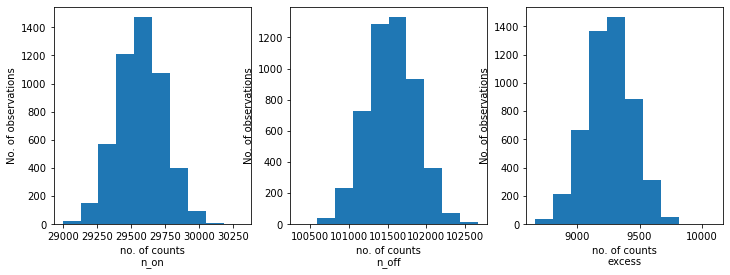

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 21min 55s, sys: 5.49 s, total: 22min 1s
Wall time: 22min 49s


In [15]:
results

[{'index': 2.285078513860973,
  'amplitude': 1.0707193841268212e-12,
  'lambda_': 1.7549757404234874},
 {'index': 2.1996324583985576,
  'amplitude': 1.2851232177832685e-12,
  'lambda_': 1.997248139660084},
 {'index': 2.2150850927687675,
  'amplitude': 1.3692600994164495e-12,
  'lambda_': 2.20388042489302},
 {'index': 2.1744685095939555,
  'amplitude': 1.462793993258135e-12,
  'lambda_': 2.2474813108859273},
 {'index': 2.243873278458896,
  'amplitude': 1.2666459861422052e-12,
  'lambda_': 1.9900955664082853},
 {'index': 2.224555841721795,
  'amplitude': 1.2790952762632778e-12,
  'lambda_': 2.0144251668081212},
 {'index': 2.3291540173955845,
  'amplitude': 9.829721114495055e-13,
  'lambda_': 1.6931848673905465},
 {'index': 2.1918609482837472,
  'amplitude': 1.4022834966072621e-12,
  'lambda_': 2.1229102661191366},
 {'index': 2.23233981236747,
  'amplitude': 1.2093207915318237e-12,
  'lambda_': 1.8886782502405552},
 {'index': 2.1711397774344117,
  'amplitude': 1.487073324677619e-12,
  'la

index: 2.217271392985661 += 0.05341546201252725


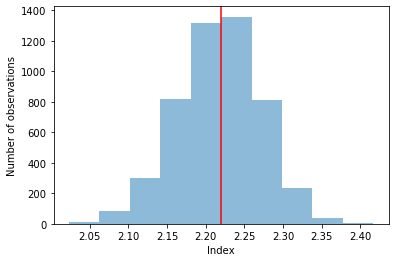

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.3129977255244364e-12 += 1.9337358356278244e-13


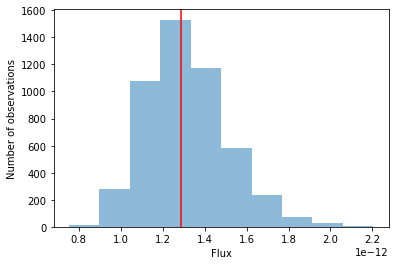

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 2.0152033725932705 += 0.2128160695876832


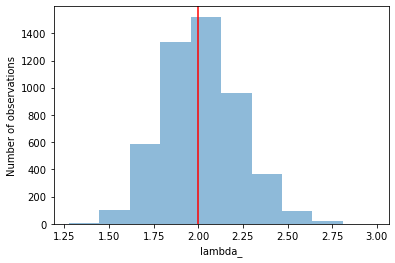

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")